#### Importing necessary libraries for leaf disease detection

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


#### Loading the dataset. Here 2152 images have been loaded into 68 batches where each batch consists of 32 images.However last batch contains less than 32 images. All images are being shuffled

In [2]:
data=tf.keras.preprocessing.image_dataset_from_directory("C:/Users/vadda/deeplearning/PlantVillage",shuffle=True,
                                                         image_size=(256,256),batch_size=32)

Found 2152 files belonging to 3 classes.


In [3]:
class_names=data.class_names

#### The following are the various classes of diseases

In [4]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

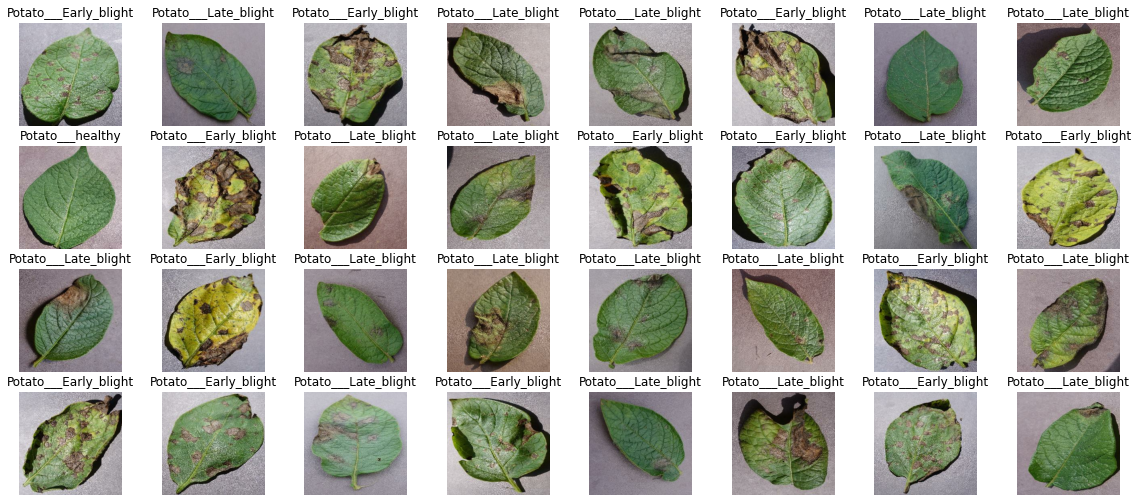

In [5]:
plt.figure(figsize=(20,20))
for img_batch,lbl_batch in data.take(1):
    test_image=img_batch[0]
    for i in range(32):
            plt.subplot(9,8,i+1)
            
            plt.imshow(img_batch[i].numpy().astype('uint8'))
            plt.title(class_names[lbl_batch[i].numpy()])
            
            plt.axis("off")
    

### Making train,test and validation splitting in data

In [6]:
def splitting(data,train_size=0.8,test_size=0.1,validation_size=0.1,shuffle=True,shuffle_size=10000):

    if shuffle:
        data=data.shuffle(shuffle_size,seed=10)
    train_size=int(train_size*len(data))
    test_size=int(test_size*len(data))
    validation_size=int(test_size*len(data))
                        
    train_ds=data.take(train_size)
    test_ds=data.skip(train_size).take(test_size)
    validation_ds=data.skip(train_size).skip(test_size)
    
    return train_ds,test_ds,validation_ds

In [7]:
train_ds,test_ds,validation_ds=splitting(data)

#### The tf.data.Dataset.cache will save some operations (like file opening and data reading) from being executed during each epoch.As it is very time consuming to open, read, mapping

#### Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

#### here buffer_size parameter tells how many batches should be loaded into CPU while GPU is under training the batches which are already being loaded

In [8]:
train_ds=train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
test_ds=test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
validation_ds=validation_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Here we resize and rescale the image. 

In [11]:
resize_rescale=tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(256,256),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

#### Here we do data augmentation i.e. image flipping (vertically and horizontally)

In [12]:
aug=tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
model=keras.models.Sequential([
    resize_rescale,
    aug,
    keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(32,256,256,3)), 
     keras.layers.MaxPooling2D((2,2)),                                 #input_shape(batch_size,size of image,channels=3(rgb))
     keras.layers.Conv2D(64,(3,3),activation='relu'),
     keras.layers.MaxPooling2D((2,2)),
     keras.layers.Conv2D(64,(3,3),activation='relu'),
     keras.layers.MaxPooling2D((2,2)),
     keras.layers.Conv2D(64,(3,3),activation='relu'),
     keras.layers.MaxPooling2D((2,2)),
     keras.layers.Conv2D(64,(3,3),activation='relu'),
     keras.layers.MaxPooling2D((2,2)),
     keras.layers.Conv2D(64,(3,3),activation='relu'),
     keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(3,activation='softmax') #final layer.
])


In [14]:
size=(32,256,256,3)
model.build(size)

In [15]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy']
             )

In [16]:
history=model.fit(train_ds,epochs=10,batch_size=32,verbose=1,validation_data=validation_ds)

Epoch 1/10
54/54 [==============================] - 105s 2s/step - loss: 0.9166 - accuracy: 0.4818 - val_loss: 0.8869 - val_accuracy: 0.5234
Epoch 2/10
54/54 [==============================] - 96s 2s/step - loss: 0.6488 - accuracy: 0.7119 - val_loss: 0.5991 - val_accuracy: 0.6992
Epoch 3/10
54/54 [==============================] - 96s 2s/step - loss: 0.4221 - accuracy: 0.8192 - val_loss: 0.4695 - val_accuracy: 0.7930
Epoch 4/10
54/54 [==============================] - 101s 2s/step - loss: 0.3362 - accuracy: 0.8680 - val_loss: 0.2432 - val_accuracy: 0.9102
Epoch 5/10
54/54 [==============================] - 98s 2s/step - loss: 0.2136 - accuracy: 0.9155 - val_loss: 0.1700 - val_accuracy: 0.9219
Epoch 6/10
54/54 [==============================] - 95s 2s/step - loss: 0.2061 - accuracy: 0.9219 - val_loss: 0.2328 - val_accuracy: 0.9023
Epoch 7/10
54/54 [==============================] - 94s 2s/step - loss: 0.1964 - accuracy: 0.9249 - val_loss: 0.1778 - val_accuracy: 0.9297
Epoch 8/10
54/54 [

In [19]:
result=model.evaluate(test_ds)

6/6 [==============================] - 5s 349ms/step - loss: 0.2346 - accuracy: 0.9062
